In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import zscore

# Sklearn imports for scaling, splitting, modeling, evaluation, and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Additional libraries for boosting models
import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostClassifier

In [7]:
# Example: Download data using yfinance library (install it if needed: pip install yfinance)
import yfinance as yf

# Define the ticker symbol (e.g., "AAPL" for Apple Inc.)
ticker = "AAPL"

# Download historical data (last 5 years)
data = yf.download(ticker, period="5y", interval="1d")

# Save the data to a CSV file for later use
data.to_csv("data/stock_data.csv")

# Display the first few rows
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-03-09  64.593887  67.486618  63.824591  64.006601  286744800
2020-03-10  69.246033  69.512981  65.370448  67.256069  285290000
2020-03-11  66.841072  68.246186  65.974706  67.316728  255598800
2020-03-12  60.240211  65.523335  60.184396  62.111268  418474000
2020-03-13  67.457497  67.930724  61.385666  64.283258  370732000

In [8]:
df = pd.read_csv(
    "data/stock_data.csv",
    skiprows=3,                # Skip the first two lines
    names=["Date", "Close", "High", "Low", "Open", "Volume"]
)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
print(df.head())
print("\nData Description:")
print(df.describe())


                Close       High        Low       Open     Volume
Date                                                             
2020-03-09  64.593887  67.486618  63.824591  64.006601  286744800
2020-03-10  69.246033  69.512981  65.370448  67.256069  285290000
2020-03-11  66.841072  68.246186  65.974706  67.316728  255598800
2020-03-12  60.240211  65.523335  60.184396  62.111268  418474000
2020-03-13  67.457497  67.930724  61.385666  64.283258  370732000

Data Description:
             Close         High          Low         Open        Volume
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03
mean    157.821496   159.413864   156.049043   157.669559  8.674388e+07
std      42.092619    42.254612    41.835021    42.030831  5.017888e+07
min      54.449886    55.452152    51.595983    55.350227  2.323470e+07
25%     130.701015   132.040753   129.038160   130.765520  5.379620e+07
50%     155.102379   157.345465   152.625028   155.106449  7.371300e+07
75%     181.741

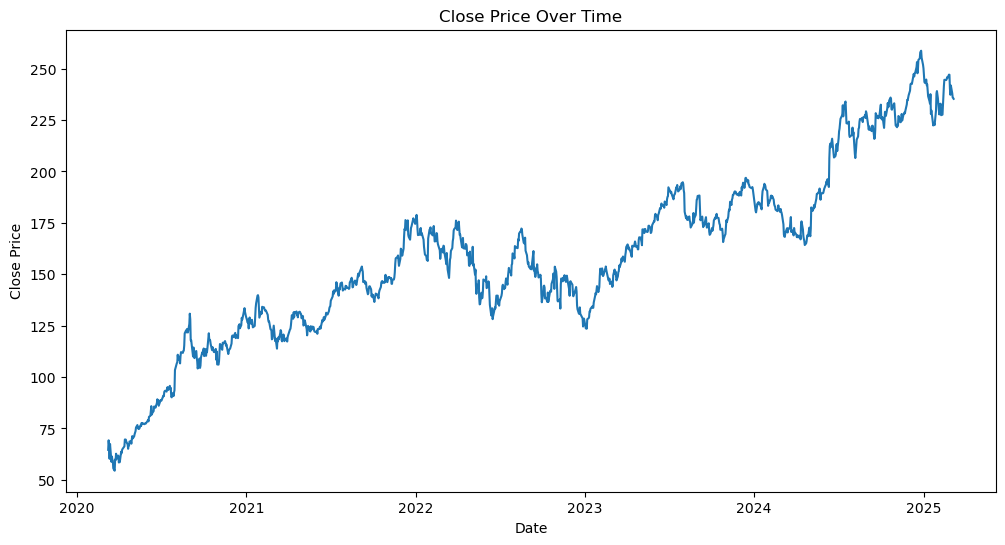

In [9]:
# Plot the Close price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [10]:
# ---------------------------
# Outlier Detection & Handling
# ---------------------------
# Remove outliers from the 'Close' column using a z-score threshold (|z| < 3)
df['Close_z'] = zscore(df['Close'])
df = df[df['Close_z'].abs() < 3]
df.drop(columns=['Close_z'], inplace=True)

In [11]:
# ---------------------------
# Feature Engineering
# ---------------------------
# Create Technical Indicators using ta (instead of pandas_ta)

# 1. Simple Moving Average (SMA) for a 20-day period
df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

# 2. Exponential Moving Average (EMA) for a 20-day period
df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

# 3. Relative Strength Index (RSI) with a 14-day period
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# 4. Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()

# Drop initial rows with NaNs after indicator calculations
df.dropna(inplace=True)

# Generate "Returns" Feature: daily percentage change in 'Close'
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# Define the binary Target: 1 if next day's Close > today's, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

# print(df.head())

In [24]:
 #Cell: Fetch and Process News Sentiment from a News API
import requests
import datetime
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Replace with your NewsAPI key
api_key = "deadcfcbb3024ab7b35a624b89533805"

# Define a date range (for example, one day or a range)
# Use recent dates (e.g., last week) instead of 2022
start_date = datetime.date.today() - datetime.timedelta(days=30)
end_date = datetime.date.today()


daily_sentiments = []
sia = SentimentIntensityAnalyzer()

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    url = f"https://newsapi.org/v2/everything?q=Apple&from={date_str}&to={date_str}&sortBy=popularity&apiKey={api_key}"
    
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        headlines = [article['title'] for article in news_data.get('articles', [])]
        if headlines:
            sentiments = [sia.polarity_scores(headline)['compound'] for headline in headlines]
            avg_sentiment = np.mean(sentiments)
            daily_sentiments.append({'date': date_str, 'num_headlines': len(headlines), 'avg_sentiment': avg_sentiment})
            # print(headlines)
            # print(f"Date: {date_str} | Headlines: {len(headlines)} | Avg Sentiment: {avg_sentiment:.4f}")
        else:
            print(f"Date: {date_str} | No headlines found.")
    else:
        print(f"Error fetching news for {date_str}: {response.status_code}")
    current_date += datetime.timedelta(days=1)

# Check if data was collected
if not daily_sentiments:
    print("No sentiment data was collected.")
else:
    df_sentiment = pd.DataFrame(daily_sentiments)
    # print("Keys in the sentiment data:", df_sentiment.columns)
    # Convert and set the index if the 'date' key is present
    if 'date' in df_sentiment.columns:
        df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
        df_sentiment.set_index('date', inplace=True)
    print("\nDaily aggregated sentiment:")
    print(df_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Error fetching news for 2025-02-06: 426
Date: 2025-03-07 | No headlines found.
Date: 2025-03-08 | No headlines found.

Daily aggregated sentiment:
            num_headlines  avg_sentiment
date                                    
2025-02-07            100       0.035835
2025-02-08             99       0.105560
2025-02-09             99       0.136167
2025-02-10             98       0.089323
2025-02-11            100       0.079063
2025-02-12             97       0.095595
2025-02-13             99       0.011582
2025-02-14             96       0.114581
2025-02-15            100       0.094480
2025-02-16             99       0.083748
2025-02-17             99      -0.014186
2025-02-18             99       0.033654
2025-02-19            100      -0.003657
2025-02-20             97       0.014251
2025-02-21             99       0.104687
2025-02-22            100       0.082511
2025-02-23             99       0.059817
2025-02-24             98       0.083183
2025-02-25             97       0

In [25]:
# ---------------------------
# Part 3: Merge Sentiment Data into the Technical Data
# ---------------------------
# Merge the sentiment data with the technical data based on the Date index.
enhanced_df = df.join(df_sentiment, how='left')

# For days without sentiment data, fill missing values with neutral sentiment (0) and 0 headlines.
if 'avg_sentiment' in enhanced_df.columns:
    enhanced_df['avg_sentiment'] = enhanced_df['avg_sentiment'].fillna(0)
    
if 'num_headlines' in enhanced_df.columns:
    enhanced_df['num_headlines'] = enhanced_df['num_headlines'].fillna(0)

# print("Enhanced DataFrame with Sentiment:")
# print(enhanced_df.head())

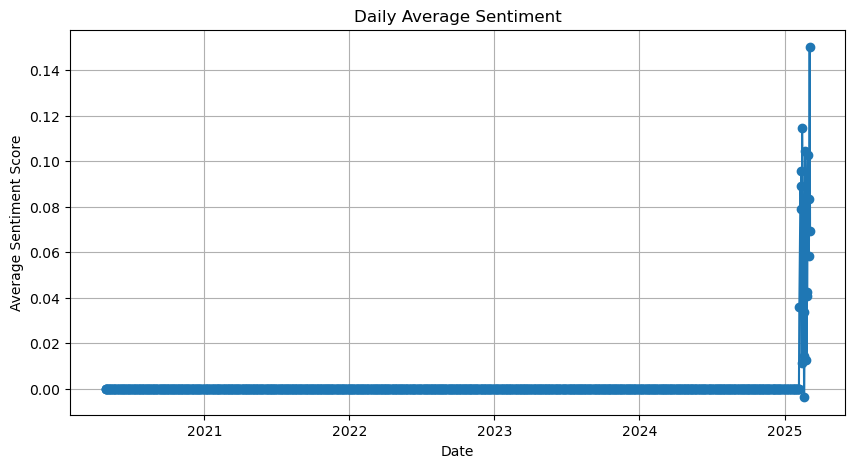

In [26]:
# Optionally, plot the daily average sentiment for visual inspection.
if 'avg_sentiment' in enhanced_df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(enhanced_df.index, enhanced_df['avg_sentiment'], marker='o')
    plt.title("Daily Average Sentiment")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.grid(True)
    plt.show()

# Save the enhanced dataset for future use
enhanced_df.to_csv("data/enhanced_stock_data.csv")

In [27]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\johni\AppData\Roaming\gcloud\application_default_credentials.json"


In [28]:
import os
credentials_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
if credentials_path:
    print("Credentials loaded from:", credentials_path)
else:
    print("No GOOGLE_APPLICATION_CREDENTIALS variable set; Application Default Credentials will be used.")


Credentials loaded from: C:\Users\johni\AppData\Roaming\gcloud\application_default_credentials.json


In [31]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def fetch_gdelt_sentiment_apple():
    """
    Queries the GDELT v2 events dataset in BigQuery to retrieve daily average tone
    for rows that mention 'APPLE' in Actor1Name or Actor2Name over the last ~6 months.
    Returns a DataFrame with columns: ['gdelt_sentiment'] indexed by date.
    """
    # Initialize BigQuery client with your project ID (replace with your actual project ID)
    client = bigquery.Client(project="machinelearning111")
    
    # Updated query using SQLDATE instead of EventDate
    query = """
    WITH filtered AS (
      SELECT
        PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) AS event_date,
        AvgTone
      FROM
        `gdelt-bq.gdeltv2.events`
      WHERE
        PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 5 YEAR)
        AND (
          LOWER(Actor1Name) LIKE '%apple%'
          OR LOWER(Actor2Name) LIKE '%apple%'
        )
    )
    SELECT
      event_date AS date,
      AVG(AvgTone) AS daily_tone
    FROM filtered
    GROUP BY date
    ORDER BY date
    """
    
    job = client.query(query)
    results = job.result()
    rows = list(results)
    
    # Convert results to DataFrame
    data = []
    for row in rows:
        data.append({'date': row.date, 'daily_tone': row.daily_tone})
    
    df_gdelt = pd.DataFrame(data)
    if not df_gdelt.empty:
        df_gdelt.set_index('date', inplace=True)
        df_gdelt.rename(columns={'daily_tone': 'gdelt_sentiment'}, inplace=True)
    else:
        df_gdelt = pd.DataFrame(columns=['gdelt_sentiment'])
    
    return df_gdelt

# Fetch GDELT data
df_gdelt = fetch_gdelt_sentiment_apple()
print("\nGDELT DataFrame (Apple mentions) Head:")
print(df_gdelt.head(50))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



GDELT DataFrame (Apple mentions) Head:
            gdelt_sentiment
date                       
2020-03-07        -2.524948
2020-03-08        -1.803441
2020-03-09        -3.928571
2020-03-10         0.561798
2020-03-11        -2.891969
2020-03-12        -0.817498
2020-03-13        -5.099516
2020-03-15        -1.202590
2020-03-16        -2.891474
2020-03-17        -2.614217
2020-03-18        -4.733626
2020-03-20        -1.780415
2020-03-21        -2.316562
2020-03-22        -2.382408
2020-03-23        -1.879699
2020-03-25         2.675781
2020-03-26        -2.808404
2020-03-30        -0.271997
2020-03-31         0.271287
2020-04-01         2.077922
2020-04-02         0.371747
2020-04-03        -2.277578
2020-04-04        -3.808354
2020-04-05        -1.618341
2020-04-06        -1.628197
2020-04-07         0.441434
2020-04-08        -0.899467
2020-04-09        -1.977644
2020-04-10         0.727070
2020-04-11         0.529568
2020-04-12         0.000000
2020-04-13         0.133281
2020-04-

In [32]:
# ---------------------------
# Part 3: Merge GDELT Sentiment into Technical Data
# ---------------------------
# Merge by date: Both DataFrames use the date as their index
even_enhanced_df = enhanced_df.join(df_gdelt, how='left')

# For days without GDELT data, fill missing values with 0
even_enhanced_df['gdelt_sentiment'] = even_enhanced_df['gdelt_sentiment'].fillna(0)

# print("Enhanced DataFrame with GDELT Sentiment:")
# print(even_enhanced_df.head())

# Save the final enhanced DataFrame
even_enhanced_df.to_csv("data/even_enhanced_stock_data.csv")

In [34]:
from fredapi import Fred

# Set your FRED API key here
fred_api_key = "7841d255497334b51d98c59632502130"  # Replace with your FRED API key
fred = Fred(api_key=fred_api_key)

# Define the date range for macro data based on your stock data
start_date_macro = df.index.min().strftime('%Y-%m-%d')
end_date_macro = df.index.max().strftime('%Y-%m-%d')
# print(start_date_macro, end_date_macro)

# Fetch daily interest rates (10-Year Treasury Constant Maturity Rate)
dgs10 = fred.get_series('DGS10', start_date_macro, end_date_macro)
df_dgs10 = pd.DataFrame(dgs10, columns=['DGS10'])
df_dgs10.index = pd.to_datetime(df_dgs10.index)

# print(df_dgs10.head(10))
# Fetch monthly CPI data
cpi = fred.get_series('CPIAUCSL', start_date_macro, end_date_macro)
df_cpi = pd.DataFrame(cpi, columns=['CPI'])
df_cpi.index = pd.to_datetime(df_cpi.index)
# Resample CPI to daily frequency using forward fill
df_cpi_daily = df_cpi.resample('D').ffill()
# print(df_cpi.head(100))
# print(df_cpi_daily.head(100))
# Fetch quarterly GDP data
gdp = fred.get_series('GDP', start_date_macro, end_date_macro)
df_gdp = pd.DataFrame(gdp, columns=['GDP'])
df_gdp.index = pd.to_datetime(df_gdp.index)
# Resample GDP to daily frequency using forward fill
df_gdp_daily = df_gdp.resample('D').ffill()
# print(df_gdp.head(100))
# print(df_gdp_daily.head(100))
# Merge macro indicators into one DataFrame
macro_df = df_dgs10.join(df_cpi_daily, how='outer').join(df_gdp_daily, how='outer')
macro_df = macro_df.ffill()
macro_df.fillna(0, inplace=True)  # For any remaining NaNs
macro_df.head()

DGS10      CPI        GDP
2020-04-01    0.0  256.032  19935.444
2020-04-02    0.0  256.032  19935.444
2020-04-03    0.0  256.032  19935.444
2020-04-04    0.0  256.032  19935.444
2020-04-05    0.0  256.032  19935.444

In [35]:
# ---------------------------
# Part 3: Merge Macro Data into Stock Data
# ---------------------------
# Merge the macro DataFrame with the technical stock DataFrame based on the date index
even_enhanced_df = df.join(macro_df, how='left')
# Fill missing macro values with the last available value or 0 if still missing
even_enhanced_df['DGS10'] = even_enhanced_df['DGS10'].ffill().fillna(0)
even_enhanced_df['CPI'] = even_enhanced_df['CPI'].ffill().fillna(0)
even_enhanced_df['GDP'] = even_enhanced_df['GDP'].ffill().fillna(0)

# print("Enhanced DataFrame with Macro Indicators:")
# print(even_enhanced_df.head())

# ---------------------------
# (Optional) Save the enhanced dataset
# ---------------------------
even_enhanced_df.to_csv("data/enhanced_stock_data_with_macro.csv")

In [37]:
# Import the necessary library from pytrends
from pytrends.request import TrendReq

# Step 1: Set up a connection to Google Trends using pytrends.
# Think of it as opening a door to ask Google about search trends.
pytrends = TrendReq(hl='en-US', tz=360)

# Step 2: Define the search term and the time period.
# We'll search for "Apple" (the company) and use a timeframe that matches our stock data.
# For example, if our stock data is from 5 years ago until today,
# we build a string with those dates.
timeframe = "all"

# List of keywords to search for. We use a list even if it has one item.
kw_list = ["Apple"]

# Step 3: Build the payload.
# This tells Google Trends what we want to know.
pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')

# Step 4: Fetch the interest over time.
# Google Trends will return a DataFrame where each row is a date and the value is how popular "Apple" is.
# Wrap in try/except to handle rate limiting
try:
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    if 'isPartial' in interest_over_time_df.columns:
        interest_over_time_df = interest_over_time_df.drop(columns=['isPartial'])
except TooManyRequestsError as e:
    print("Too many requests. Waiting for 60 seconds before retrying...")
    time.sleep(60)
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    if 'isPartial' in interest_over_time_df.columns:
        interest_over_time_df = interest_over_time_df.drop(columns=['isPartial'])
# Print the first few rows so we can see what it looks like.
print("Google Trends Interest Over Time for 'Apple':")
print(interest_over_time_df.head())

# Optional: If the data is weekly and you want daily values,
# you could resample it (for example, using forward fill). Uncomment if needed.
# interest_over_time_daily = interest_over_time_df.resample('D').ffill()
# print("Resampled Daily Google Trends Data:")
# print(interest_over_time_daily.head())


Google Trends Interest Over Time for 'Apple':
            Apple
date             
2004-01-01     21
2004-02-01     19
2004-03-01     18
2004-04-01     19
2004-05-01     18
Resampled Daily Google Trends Data:


D:\Users\johni\anaconda3\envs\tf_env\lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


NameError: name 'interest_over_time_daily' is not defined

In [38]:
# ---------------------------
# Merge Google Trends Data into Enhanced DataFrame
# ---------------------------
# 'even_enhanced_df' is your DataFrame with stock, macro, news, and GDELT data
# It is indexed by date; join on date
even_enhanced_df = even_enhanced_df.join(interest_over_time_df, how='left')
# Fill missing values in the "Apple" column with the last available value, then with 0 if still missing
even_enhanced_df['Apple'] = even_enhanced_df['Apple'].ffill().fillna(0)

# ---------------------------
# Final: Save the Fully Enhanced Dataset
# ---------------------------
even_enhanced_df.to_csv("data/even_enhanced_stock_data.csv")
# even_enhanced_df.head(50)

In [41]:
featured_df = even_enhanced_df.copy()
# Create a group column where each row is labeled by its trading day.
featured_df['group'] = featured_df.index.date
# Verify that the group labels are set correctly
print(featured_df[['group']].head())
featured_df.to_csv("data/featured_stock_data.csv")

                 group
Date                  
2020-04-27  2020-04-27
2020-04-28  2020-04-28
2020-04-29  2020-04-29
2020-04-30  2020-04-30
2020-05-01  2020-05-01


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# Fixed PurgedEmbargoedTimeSeriesSplit with embargo applied to the test set.
class PurgedEmbargoedTimeSeriesSplit(_BaseKFold):
    """Custom Time-Series CV that purges a specified gap between training and test sets 
    and applies an embargo period to shift the test set.
    
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits/folds.
    purge : int, default=0
        Number of groups to exclude immediately before the test set.
    embargo : int, default=0
        Number of groups to shift the test set forward (embargo period).
    max_train_group_size : int, default=np.inf
        Optional maximum number of groups for training.
    """
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, purge=0, embargo=0, max_train_group_size=np.inf):
        if n_splits < 2:
            raise ValueError("n_splits must be at least 2.")
        self.n_splits = n_splits
        self.purge = purge
        self.embargo = embargo
        self.max_train_group_size = max_train_group_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test sets.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data to split.
        y : array-like, optional
            Not used, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels (e.g., trading days). Must be provided.
            
        Yields
        ------
        train : ndarray
            The training set indices for that fold.
        test : ndarray
            The test set indices for that fold.
        """
        if groups is None:
            raise ValueError("The 'groups' parameter must be provided.")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        # Obtain unique groups in order of appearance
        unique_groups, group_start_idx = np.unique(groups, return_index=True)
        sorted_groups = unique_groups[np.argsort(group_start_idx)]
        n_groups = len(sorted_groups)
        
        if self.n_splits + 1 > n_groups:
            raise ValueError("Not enough groups for the number of splits requested.")
        
        # Determine test group size (number of groups per test fold)
        test_group_size = n_groups // (self.n_splits + 1)
        
        for i in range(self.n_splits):
            raw_test_start = (i + 1) * test_group_size
            # Training groups: groups before raw_test_start minus purge gap.
            train_end = max(raw_test_start - self.purge, 0)
            train_groups = sorted_groups[:train_end]
            # If a maximum train group size is defined, keep only the latest groups.
            if len(train_groups) > self.max_train_group_size:
                train_groups = train_groups[-self.max_train_group_size:]
            
            # Apply embargo: shift test set forward by embargo groups.
            actual_test_start = raw_test_start + self.embargo
            actual_test_end = actual_test_start + test_group_size
            test_groups = sorted_groups[actual_test_start:actual_test_end]
            
            # Convert group labels to indices
            train_idx = np.hstack([np.where(groups == grp)[0] for grp in train_groups])
            test_idx = np.hstack([np.where(groups == grp)[0] for grp in test_groups])
            
            yield train_idx, test_idx


# ---------------------------
# Define the PurgedGroupTimeSeriesSplit Class
# ---------------------------
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """
    Time Series cross-validator variant that purges a specified gap between training 
    and test sets to avoid leakage.
    
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits.
    group_gap : int, default=None
        Gap between train and test groups to prevent leakage.
    max_train_group_size : int, default=np.inf
        Maximum number of groups for training.
    """
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, group_gap=None, max_train_group_size=np.inf):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.group_gap = group_gap
        self.max_train_group_size = max_train_group_size

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_groups = len(unique_groups)
        for idx in np.arange(n_samples):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError("Cannot have number of folds={} greater than number of groups={}".format(n_folds, n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size, n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            # Exclude groups within the gap period
            group_st = max(0, group_test_start - self.group_gap - self.max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - self.group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(np.concatenate((train_array, train_array_tmp)), axis=None), axis=None)
            for test_group_idx in unique_groups[group_test_start:group_test_start + group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(np.concatenate((test_array, test_array_tmp)), axis=None), axis=None)
            # Further remove the first `group_gap` indices from test set if specified
            test_array = test_array[self.group_gap:]
            yield [int(i) for i in train_array], [int(i) for i in test_array]


In [5]:
def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls=1e-2, lr=1e-3):
    inp = tf.keras.layers.Input(shape=(num_columns,))
    x0 = tf.keras.layers.BatchNormalization()(inp)
    
    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name='decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)
    out_ae = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='ae_action')(x_ae)
    
    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i+2])(x)
        
    out = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='action')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=[decoder, out_ae, out])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss={'decoder': tf.keras.losses.MeanSquaredError(),
                        'ae_action': tf.keras.losses.BinaryCrossentropy(label_smoothing=ls),
                        'action': tf.keras.losses.BinaryCrossentropy(label_smoothing=ls)},
                  metrics={'decoder': tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                           'ae_action': tf.keras.metrics.AUC(name='AUC'),
                           'action': tf.keras.metrics.AUC(name='AUC')})
    return model


In [7]:
# ---------------------------
# Testing the PurgedEmbargoedTimeSeriesSplit Function
# ---------------------------
# Create synthetic data with a group label.
# For simplicity, let's assume we have 30 days of data.
dates = pd.date_range(start='2022-01-01', periods=30, freq='D')
# We'll use the date (as string) as the group label.
groups = dates.strftime('%Y-%m-%d').values

# Create a dummy feature matrix (30 samples, 2 features) and target vector.
X_dummy = np.random.randn(30, 2)
y_dummy = np.random.randint(0, 2, size=(30,))

# Instantiate the splitter with, for example, 3 splits, a purge of 1 group, and an embargo of 1 group.
cv = PurgedEmbargoedTimeSeriesSplit(n_splits=3, purge=1, embargo=1)

# Print the training and test groups for each fold.
print("Testing PurgedEmbargoedTimeSeriesSplit:")
for fold, (train_idx, test_idx) in enumerate(cv.split(X_dummy, y_dummy, groups=groups), 1):
    print(f"\nFold {fold}:")
    print("Training groups:", np.unique(groups[train_idx]))
    print("Test groups:", np.unique(groups[test_idx]))
    # For clarity, print the indices too.
    print("Train indices:", train_idx)
    print("Test indices:", test_idx)

Testing PurgedEmbargoedTimeSeriesSplit:

Fold 1:
Training groups: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06']
Test groups: ['2022-01-09' '2022-01-10' '2022-01-11' '2022-01-12' '2022-01-13'
 '2022-01-14' '2022-01-15']
Train indices: [0 1 2 3 4 5]
Test indices: [ 8  9 10 11 12 13 14]

Fold 2:
Training groups: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13']
Test groups: ['2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '2022-01-20'
 '2022-01-21' '2022-01-22']
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Test indices: [15 16 17 18 19 20 21]

Fold 3:
Training groups: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13' '2022-01-14' '2022-01-15'
 '2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '202

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Step 1: Load Enhanced Data ---
# Load your fully enhanced dataset (technical, sentiment, macro, and Google Trends merged)
featured_df = pd.read_csv("data/featured_stock_data.csv", parse_dates=['Date'], index_col='Date')

print("Initial Enhanced DataFrame Shape:", featured_df.shape)
print(featured_df.head(10))

# --- Step 2: Data Filtering ---
# Optionally, filter out early data if you suspect quality issues
# featured_df = featured_df[featured_df.index > '2020-03-01']

# --- Step 3: Handle Missing Values ---
# Forward-fill missing values and then fill any remaining NaNs with 0
featured_df.ffill(inplace=True)
featured_df.fillna(0, inplace=True)


# --- Step 5: Compute Sample Weights (Optional) ---
# Compute a rolling average of absolute daily returns to serve as sample weights
featured_df['sample_weight'] = featured_df['Return'].abs().rolling(window=5).mean().fillna(1)

# --- Step 6: Define Features and Prepare Data ---
# Exclude the target and sample_weight columns from the features
feature_cols = [col for col in featured_df.columns if col not in ['Target', 'sample_weight', 'group']]
X = featured_df[feature_cols]
y = featured_df['Target']
sample_weight = featured_df['sample_weight']

# --- Step 7: Scale Features ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

# --- Step 8: (Optional) Chronological Train/Test Split ---
# This step is useful for later modeling; here we print sizes for verification.
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled.iloc[:train_size]
X_test  = X_scaled.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]
sw_train = sample_weight.iloc[:train_size]

print("Training set size:", X_train.shape, " Testing set size:", X_test.shape)
print("Sample target distribution (first 5 rows):")
print(y_train.head())
print(X_train.head())
# At this point, your data is preprocessed similarly to the winning code,
# but adapted to your stock data. You don't have multiple 'resp' columns,
# so you don't need to create a composite target from them.
# Instead, you use a single target based on the next day's Close price.
# You also compute sample weights based on volatility (absolute returns).


Initial Enhanced DataFrame Shape: (1222, 18)
                Close       High        Low       Open     Volume      SMA20  \
Date                                                                           
2020-04-27  68.719421  69.051890  67.937995  68.386945  117087600  65.148397   
2020-04-28  67.605507  69.364929  67.513295  69.182920  112004800  65.436820   
2020-04-29  69.826050  70.296848  68.894163  69.098013  137280800  65.842580   
2020-04-30  71.299088  71.476246  69.976491  70.367201  183064000  66.484344   
2020-05-01  70.151230  72.561031  69.369803  69.466873  240616800  67.019937   
2020-05-04  71.143784  71.272403  69.483860  70.175497  133568000  67.647869   
2020-05-05  72.211578  73.046395  71.459272  71.604881  147751200  68.073650   
2020-05-06  72.956581  73.589970  72.529464  72.915322  142333600  68.573568   
2020-05-07  73.711319  74.058356  73.281780  73.585129  115215200  69.030654   
2020-05-08  75.465782  75.519316  74.044701  74.373206  133838400  69.55216

In [17]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
# ---------------------------
# Prepare Grouping Variable
# ---------------------------
# Use the 'group' column for time-series splitting, converting to string
groups = featured_df['group'].astype(str).values

# ---------------------------
# Define Model Hyperparameters for Your Stock Prediction Task
# ---------------------------
# Since you have a binary target, set num_labels to 1.
params = {
    'num_columns': X_scaled.shape[1],
    'num_labels': 1,  # Binary target
    'hidden_units': [96, 96, 896, 448, 448, 256],
    'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436,
                      0.10431484318345882, 0.49230389137187497, 0.32024444956111164,
                      0.2716856145683449, 0.4379233941604448],
    'ls': 0,
    'lr': 1e-3,
}

# ---------------------------
# Define Cross-Validation Parameters
# ---------------------------
n_splits = 5
group_gap = 31  # As per your specification

# Instantiate the custom time-series splitter (PurgedGroupTimeSeriesSplit)
# (Assuming PurgedGroupTimeSeriesSplit is defined as below.)
cv = PurgedGroupTimeSeriesSplit(n_splits=n_splits, group_gap=group_gap)

In [44]:
# ---------------------------
# Training Loop Using Cross-Validation
# ---------------------------
# We'll perform cross-validation using PurgedGroupTimeSeriesSplit.
# Here, we use the preprocessed data: X (features), y (target), sample_weight, and groups.

# Define cross-validation parameters
n_splits = 5
group_gap = 31  # gap to avoid leakage

# Instantiate the splitter
gkf = PurgedGroupTimeSeriesSplit(n_splits=n_splits, group_gap=group_gap)

# Initialize list to store ROC AUC scores for each fold
cv_scores = []

# Training parameters
batch_size = 4096
epochs = 100

# Loop over each fold in the cross-validation splitter
# Training loop using cross-validation
# Loop over each fold in the cross-validation splitter
fold = 0
for tr_idx, te_idx in gkf.split(X.values, y.values.reshape(-1, 1), groups=groups):
    fold += 1
    print(f"\nTraining Fold {fold}")
    
    # Create a new model instance for the current fold
    model = create_ae_mlp(**params)
    
    # Define checkpoint file path for the current fold
    ckp_path = f'StockModel_Fold{fold}.weights.h5'
    
    # Setup callbacks
    checkpoint = ModelCheckpoint(
        ckp_path, monitor='val_action_AUC', save_best_only=True,
        save_weights_only=True, mode='max', verbose=0
    )
    early_stop = EarlyStopping(
        monitor='val_action_AUC', min_delta=1e-4, patience=10,
        restore_best_weights=True, mode='max', verbose=0
    )
    
    # Extract training and validation data for this fold
    X_train_fold = X.values[tr_idx]
    X_val_fold   = X.values[te_idx]
    y_train_fold = y.values.reshape(-1, 1)[tr_idx]
    y_val_fold   = y.values.reshape(-1, 1)[te_idx]
    sw_train_fold = sample_weight.values[tr_idx]
    
    # Create sample weights for the decoder output
    sw_decoder = np.tile(sw_train_fold.reshape(-1, 1), (1, X_train_fold.shape[1]))
    
    # Train the model
    history = model.fit(
        X_train_fold,
        [X_train_fold, y_train_fold, y_train_fold],  # Targets for decoder, ae_action, action
        validation_data=(
            X_val_fold,
            [X_val_fold, y_val_fold, y_val_fold]
        ),
        sample_weight=[sw_train_fold, sw_train_fold, sw_train_fold],  # List of 1D sample weights
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stop],
        verbose=0
    )
    
    # Record best validation ROC AUC
    fold_history = pd.DataFrame(history.history)
    best_auc = fold_history['val_action_AUC'].max()
    print(f"Fold {fold} best validation ROC AUC: {best_auc:.4f}")
    
    # Clean up
    cv_scores.append(best_auc)
    K.clear_session()
    del model
    gc.collect()

# Compute and print the average ROC AUC across all folds
avg_auc = np.mean(cv_scores)
print("\nAverage Cross-Validation ROC AUC:", avg_auc)


Training Fold 1
Fold 1 best validation ROC AUC: 0.5605

Training Fold 2
Fold 2 best validation ROC AUC: 0.5000

Training Fold 3
Fold 3 best validation ROC AUC: 0.5517

Training Fold 4
Fold 4 best validation ROC AUC: 0.5243

Training Fold 5
Fold 5 best validation ROC AUC: 0.5765

Average Cross-Validation ROC AUC: 0.5425985932350159


In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import zscore

# Sklearn imports for scaling, splitting, modeling, evaluation, and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import numpy as np
import pandas as pd
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# Fixed PurgedEmbargoedTimeSeriesSplit with embargo applied to the test set.
class PurgedEmbargoedTimeSeriesSplit(_BaseKFold):
    """Custom Time-Series CV that purges a specified gap between training and test sets 
    and applies an embargo period to shift the test set.
    
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits/folds.
    purge : int, default=0
        Number of groups to exclude immediately before the test set.
    embargo : int, default=0
        Number of groups to shift the test set forward (embargo period).
    max_train_group_size : int, default=np.inf
        Optional maximum number of groups for training.
    """
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, purge=0, embargo=0, max_train_group_size=np.inf):
        if n_splits < 2:
            raise ValueError("n_splits must be at least 2.")
        self.n_splits = n_splits
        self.purge = purge
        self.embargo = embargo
        self.max_train_group_size = max_train_group_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test sets.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data to split.
        y : array-like, optional
            Not used, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels (e.g., trading days). Must be provided.
            
        Yields
        ------
        train : ndarray
            The training set indices for that fold.
        test : ndarray
            The test set indices for that fold.
        """
        if groups is None:
            raise ValueError("The 'groups' parameter must be provided.")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        # Obtain unique groups in order of appearance
        unique_groups, group_start_idx = np.unique(groups, return_index=True)
        sorted_groups = unique_groups[np.argsort(group_start_idx)]
        n_groups = len(sorted_groups)
        
        if self.n_splits + 1 > n_groups:
            raise ValueError("Not enough groups for the number of splits requested.")
        
        # Determine test group size (number of groups per test fold)
        test_group_size = n_groups // (self.n_splits + 1)
        
        for i in range(self.n_splits):
            raw_test_start = (i + 1) * test_group_size
            # Training groups: groups before raw_test_start minus purge gap.
            train_end = max(raw_test_start - self.purge, 0)
            train_groups = sorted_groups[:train_end]
            # If a maximum train group size is defined, keep only the latest groups.
            if len(train_groups) > self.max_train_group_size:
                train_groups = train_groups[-self.max_train_group_size:]
            
            # Apply embargo: shift test set forward by embargo groups.
            actual_test_start = raw_test_start + self.embargo
            actual_test_end = actual_test_start + test_group_size
            test_groups = sorted_groups[actual_test_start:actual_test_end]
            
            # Convert group labels to indices
            train_idx = np.hstack([np.where(groups == grp)[0] for grp in train_groups])
            test_idx = np.hstack([np.where(groups == grp)[0] for grp in test_groups])
            
            yield train_idx, test_idx


# ---------------------------
# Define the PurgedGroupTimeSeriesSplit Class
# ---------------------------
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """
    Time Series cross-validator variant that purges a specified gap between training 
    and test sets to avoid leakage.
    
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits.
    group_gap : int, default=None
        Gap between train and test groups to prevent leakage.
    max_train_group_size : int, default=np.inf
        Maximum number of groups for training.
    """
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, group_gap=None, max_train_group_size=np.inf):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.group_gap = group_gap
        self.max_train_group_size = max_train_group_size

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_groups = len(unique_groups)
        for idx in np.arange(n_samples):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError("Cannot have number of folds={} greater than number of groups={}".format(n_folds, n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size, n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            # Exclude groups within the gap period
            group_st = max(0, group_test_start - self.group_gap - self.max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - self.group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(np.concatenate((train_array, train_array_tmp)), axis=None), axis=None)
            for test_group_idx in unique_groups[group_test_start:group_test_start + group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(np.concatenate((test_array, test_array_tmp)), axis=None), axis=None)
            # Further remove the first `group_gap` indices from test set if specified
            test_array = test_array[self.group_gap:]
            yield [int(i) for i in train_array], [int(i) for i in test_array]

def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls=1e-2, lr=1e-3):
    inp = tf.keras.layers.Input(shape=(num_columns,))
    x0 = tf.keras.layers.BatchNormalization()(inp)
    
    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name='decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)
    out_ae = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='ae_action')(x_ae)
    
    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i+2])(x)
        
    out = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='action')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=[decoder, out_ae, out])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss={'decoder': tf.keras.losses.MeanSquaredError(),
                        'ae_action': tf.keras.losses.BinaryCrossentropy(label_smoothing=ls),
                        'action': tf.keras.losses.BinaryCrossentropy(label_smoothing=ls)},
                  metrics={'decoder': tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                           'ae_action': tf.keras.metrics.AUC(name='AUC'),
                           'action': tf.keras.metrics.AUC(name='AUC')})
    return model

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Step 1: Load Enhanced Data ---
# Load your fully enhanced dataset (technical, sentiment, macro, and Google Trends merged)
featured_df = pd.read_csv("data/featured_stock_data.csv", parse_dates=['Date'], index_col='Date')

print("Initial Enhanced DataFrame Shape:", featured_df.shape)
print(featured_df.head(10))

# --- Step 2: Data Filtering ---
# Optionally, filter out early data if you suspect quality issues
# featured_df = featured_df[featured_df.index > '2020-03-01']

# --- Step 3: Handle Missing Values ---
# Forward-fill missing values and then fill any remaining NaNs with 0
featured_df.ffill(inplace=True)
featured_df.fillna(0, inplace=True)


# --- Step 5: Compute Sample Weights (Optional) ---
# Compute a rolling average of absolute daily returns to serve as sample weights
featured_df['sample_weight'] = featured_df['Return'].abs().rolling(window=5).mean().fillna(1)

# --- Step 6: Define Features and Prepare Data ---
# Exclude the target and sample_weight columns from the features
feature_cols = [col for col in featured_df.columns if col not in ['Target', 'sample_weight', 'group']]
X = featured_df[feature_cols]
y = featured_df['Target']
sample_weight = featured_df['sample_weight']

# --- Step 7: Scale Features ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

# --- Step 8: (Optional) Chronological Train/Test Split ---
# This step is useful for later modeling; here we print sizes for verification.
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled.iloc[:train_size]
X_test  = X_scaled.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]
sw_train = sample_weight.iloc[:train_size]

print("Training set size:", X_train.shape, " Testing set size:", X_test.shape)
print("Sample target distribution (first 5 rows):")
print(y_train.head())
print(X_train.head())
# At this point, your data is preprocessed similarly to the winning code,
# but adapted to your stock data. You don't have multiple 'resp' columns,
# so you don't need to create a composite target from them.
# Instead, you use a single target based on the next day's Close price.
# You also compute sample weights based on volatility (absolute returns).

import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
# ---------------------------
# Prepare Grouping Variable
# ---------------------------
# Use the 'group' column for time-series splitting, converting to string
groups = featured_df['group'].astype(str).values

# ---------------------------
# Define Model Hyperparameters for Your Stock Prediction Task
# ---------------------------
# Since you have a binary target, set num_labels to 1.
params = {
    'num_columns': X_scaled.shape[1],
    'num_labels': 1,  # Binary target
    'hidden_units': [96, 96, 896, 448, 448, 256],
    'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436,
                      0.10431484318345882, 0.49230389137187497, 0.32024444956111164,
                      0.2716856145683449, 0.4379233941604448],
    'ls': 0,
    'lr': 1e-3,
}

# ---------------------------
# Define Cross-Validation Parameters
# ---------------------------
n_splits = 5
group_gap = 31  # As per your specification

# Instantiate the custom time-series splitter (PurgedGroupTimeSeriesSplit)
# (Assuming PurgedGroupTimeSeriesSplit is defined as below.)
cv = PurgedGroupTimeSeriesSplit(n_splits=n_splits, group_gap=group_gap)

# ---------------------------
# Training Loop Using Cross-Validation
# ---------------------------
# We'll perform cross-validation using PurgedGroupTimeSeriesSplit.
# Here, we use the preprocessed data: X (features), y (target), sample_weight, and groups.

# Define cross-validation parameters
n_splits = 5
group_gap = 31  # gap to avoid leakage

# Instantiate the splitter
gkf = PurgedGroupTimeSeriesSplit(n_splits=n_splits, group_gap=group_gap)

# Initialize list to store ROC AUC scores for each fold
cv_scores = []

# Training parameters
batch_size = 4096
epochs = 100

# Loop over each fold in the cross-validation splitter
# Training loop using cross-validation
# Loop over each fold in the cross-validation splitter
fold = 0
for tr_idx, te_idx in gkf.split(X.values, y.values.reshape(-1, 1), groups=groups):
    fold += 1
    print(f"\nTraining Fold {fold}")
    
    # Create a new model instance for the current fold
    model = create_ae_mlp(**params)
    
    # Define checkpoint file path for the current fold
    ckp_path = f'StockModel_Fold{fold}.weights.h5'
    
    # Setup callbacks
    checkpoint = ModelCheckpoint(
        ckp_path, monitor='val_action_AUC', save_best_only=True,
        save_weights_only=True, mode='max', verbose=0
    )
    early_stop = EarlyStopping(
        monitor='val_action_AUC', min_delta=1e-4, patience=10,
        restore_best_weights=True, mode='max', verbose=0
    )
    
    # Extract training and validation data for this fold
    X_train_fold = X.values[tr_idx]
    X_val_fold   = X.values[te_idx]
    y_train_fold = y.values.reshape(-1, 1)[tr_idx]
    y_val_fold   = y.values.reshape(-1, 1)[te_idx]
    sw_train_fold = sample_weight.values[tr_idx]
    
    # Create sample weights for the decoder output
    sw_decoder = np.tile(sw_train_fold.reshape(-1, 1), (1, X_train_fold.shape[1]))
    
    # Train the model
    history = model.fit(
        X_train_fold,
        [X_train_fold, y_train_fold, y_train_fold],  # Targets for decoder, ae_action, action
        validation_data=(
            X_val_fold,
            [X_val_fold, y_val_fold, y_val_fold]
        ),
        sample_weight=[sw_train_fold, sw_train_fold, sw_train_fold],  # List of 1D sample weights
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stop],
        verbose=0
    )
    
    # Record best validation ROC AUC
    fold_history = pd.DataFrame(history.history)
    best_auc = fold_history['val_action_AUC'].max()
    print(f"Fold {fold} best validation ROC AUC: {best_auc:.4f}")
    
    # Clean up
    cv_scores.append(best_auc)
    K.clear_session()
    del model
    gc.collect()

# Compute and print the average ROC AUC across all folds
avg_auc = np.mean(cv_scores)
print("\nAverage Cross-Validation ROC AUC:", avg_auc)


Initial Enhanced DataFrame Shape: (1222, 18)
                Close       High        Low       Open     Volume      SMA20  \
Date                                                                           
2020-04-27  68.719421  69.051890  67.937995  68.386945  117087600  65.148397   
2020-04-28  67.605507  69.364929  67.513295  69.182920  112004800  65.436820   
2020-04-29  69.826050  70.296848  68.894163  69.098013  137280800  65.842580   
2020-04-30  71.299088  71.476246  69.976491  70.367201  183064000  66.484344   
2020-05-01  70.151230  72.561031  69.369803  69.466873  240616800  67.019937   
2020-05-04  71.143784  71.272403  69.483860  70.175497  133568000  67.647869   
2020-05-05  72.211578  73.046395  71.459272  71.604881  147751200  68.073650   
2020-05-06  72.956581  73.589970  72.529464  72.915322  142333600  68.573568   
2020-05-07  73.711319  74.058356  73.281780  73.585129  115215200  69.030654   
2020-05-08  75.465782  75.519316  74.044701  74.373206  133838400  69.55216

ROC AUC Scores per Fold: [0.5304853320121765, 0.5856910943984985, 0.525611400604248, 0.5319811105728149, 0.6343077421188354]
Average ROC AUC: 0.5616153359413147


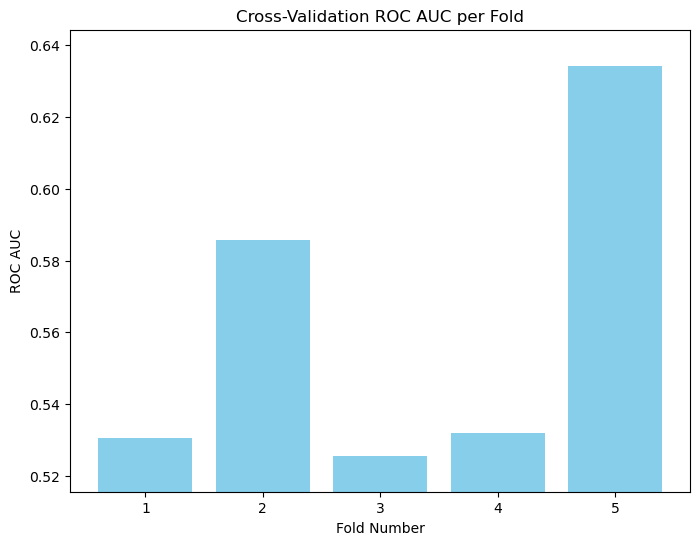

In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_and_plot_predictions(model, X_test, y_test, df_test):
    # Obtain predictions from the main output ('action')
    y_pred_prob = model.predict(X_test)[2]
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Compute and print performance metrics
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Create a signal Series for plotting
    signal = pd.Series(y_pred.flatten(), index=df_test.index)
    
    # Create a colour list for scatter plot: red if signal==1, blue if 0
    colors = ['red' if pred == 1 else 'blue' for pred in signal.values]
    
    # Plot the test set Close price with colour indicating prediction
    plt.figure(figsize=(12, 6))
    plt.scatter(df_test.index, df_test['Close'], c=colors, alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("Model Predictions on Test Data (Red: Up, Blue: Down)")
    
    # Custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Predicted Up (1)', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Predicted Down (0)', markerfacecolor='blue', markersize=10)
    ]
    plt.legend(handles=legend_elements)
    plt.grid(True)
    plt.show()
    
    return y_pred, y_pred_prob


display_cv_performance(cv_scores)

In [53]:
# ---------------------------
# Define Evaluation Function
# ---------------------------
def evaluate_model_performance(model, X_test, y_test, test_returns):
    # Predict using the 'action' output (main classifier)
    y_pred_prob = model.predict(X_test)[2]
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Compute classification metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)
    print("ROC AUC:", roc_auc)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Simulate profit: if prediction is 1, profit equals the day's return; otherwise, 0.
    profit = np.sum(test_returns[y_pred.flatten() == 1])
    print("Total Estimated Profit on Test Data: $", profit)
    
    return acc, prec, rec, f1, roc_auc, profit

In [57]:
# ---------------------------
# Train Final Model on Training Set and Evaluate on Test Set
# ---------------------------
final_model = create_ae_mlp(**params)
final_model.fit(
    X_train.values,
    [X_train.values, y_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1)],
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)
# Evaluate final model on hold-out test set
print("\nEvaluating final model on test set...")
acc, prec, rec, f1, roc_auc, profit = evaluate_model_performance(final_model, X_test.values, y_test.values.reshape(-1, 1), 
                                                                  featured_df['Return'].iloc[train_size:].values)


Evaluating final model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
Accuracy: 0.4897959183673469
Precision: 0.6103896103896104
Recall: 0.33098591549295775
F1-score: 0.4292237442922374
ROC AUC: 0.5600300834131

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.71      0.54       103
           1       0.61      0.33      0.43       142

    accuracy                           0.49       245
   macro avg       0.52      0.52      0.48       245
weighted avg       0.54      0.49      0.48       245


Confusion Matrix:
[[73 30]
 [95 47]]
Total Estimated Profit on Test Data: $ 0.4621774218654873


Generating predictions for Fold 1


D:\Users\johni\anaconda3\envs\tf_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Generating predictions for Fold 2
Generating predictions for Fold 3
Generating predictions for Fold 4
Generating predictions for Fold 5


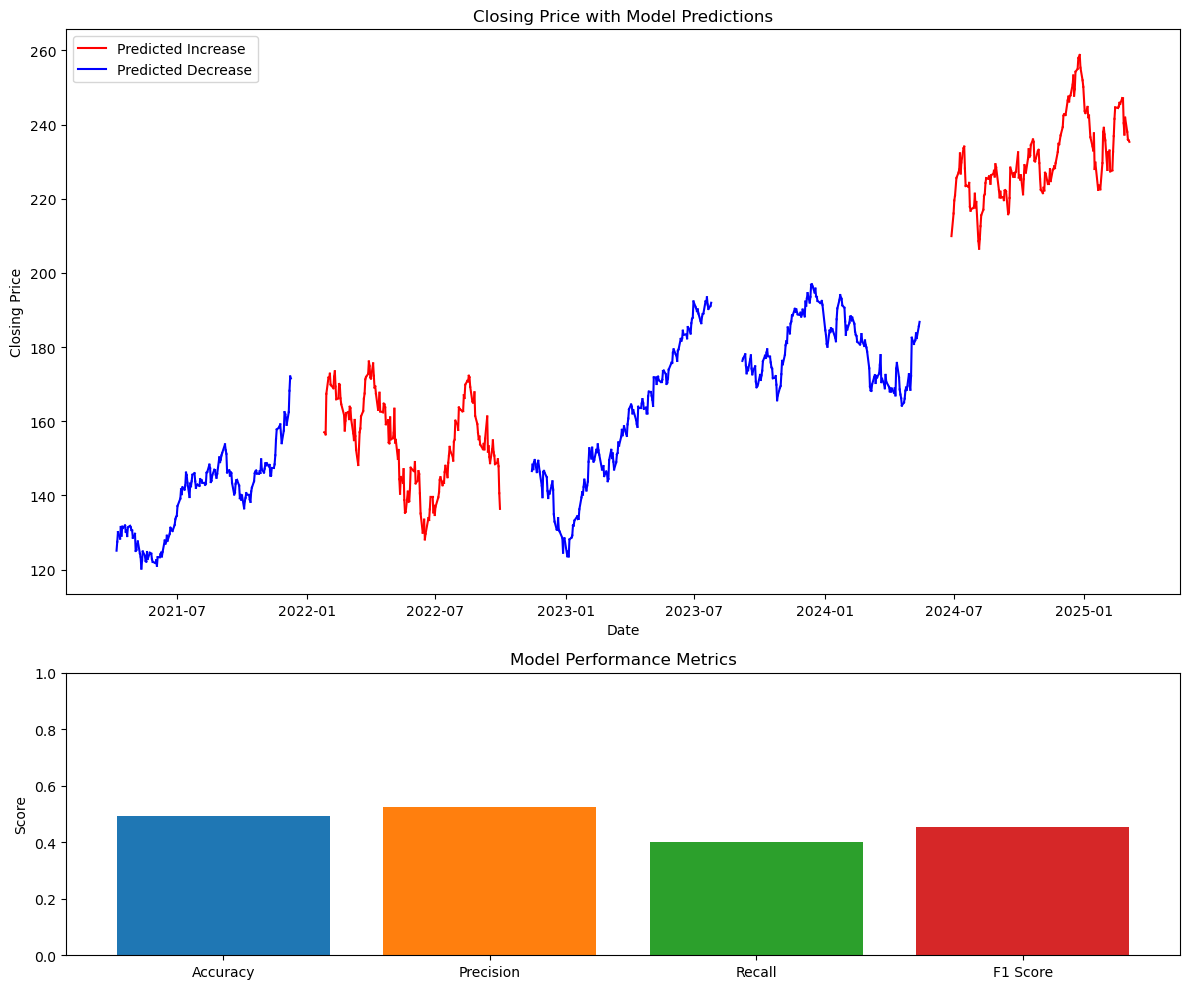

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import tensorflow as tf

# Collect predictions and true labels from all folds
all_y_true = []
all_y_pred = []

for fold in range(1, n_splits + 1):
    print(f"Generating predictions for Fold {fold}")
    
    # Load the best model for this fold
    model = create_ae_mlp(**params)
    model.load_weights(f'StockModel_Fold{fold}.weights.h5')
    
    # Get test indices for this fold
    _, te_idx = list(gkf.split(X.values, y.values.reshape(-1, 1), groups=groups))[fold - 1]
    
    # Get test data
    X_test_fold = X.values[te_idx]
    y_test_fold = y.values[te_idx]
    
    # Predict using the model
    _, _, y_pred_fold = model.predict(X_test_fold, verbose=0)
    y_pred_binary = (y_pred_fold > 0.5).astype(int).flatten()  # Threshold at 0.5 for binary classification
    
    # Append to lists
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred_binary)
    
    # Clean up
    tf.keras.backend.clear_session()
    del model

# Convert lists to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# --- Step 1: Compute Performance Metrics ---
accuracy = accuracy_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred)
recall = recall_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred)

# --- Step 2: Create the Figure with Two Subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# --- Plot 1: Closing Prices with Colored Predictions ---
# Use the Date index and Close prices from featured_df
dates = featured_df.index
close_prices = featured_df['Close']

# Create a mask for test indices across all folds
test_mask = np.zeros(len(featured_df), dtype=bool)
for _, te_idx in gkf.split(X.values, y.values.reshape(-1, 1), groups=groups):
    test_mask[te_idx] = True

# Map predictions to the original dataset (only for test indices)
pred_series = pd.Series(index=featured_df.index, dtype=float)
pred_series.iloc[test_mask] = all_y_pred

# Plot closing prices with colors based on predictions
for i in range(len(dates) - 1):
    if pd.notna(pred_series.iloc[i]):
        color = 'red' if pred_series.iloc[i] == 1 else 'blue'
        ax1.plot(dates[i:i+2], close_prices[i:i+2], color=color)

# Add legend and labels for the closing price plot
ax1.plot([], [], color='red', label='Predicted Increase')
ax1.plot([], [], color='blue', label='Predicted Decrease')
ax1.legend()
ax1.set_title('Closing Price with Model Predictions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price')

# --- Plot 2: Performance Metrics Bar Chart ---
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

ax2.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax2.set_ylim(0, 1)  # Scores range from 0 to 1
ax2.set_title('Model Performance Metrics')
ax2.set_ylabel('Score')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()